In [11]:
# The data referenced here have been saved after extraction and condensing in individual files.
# This has been done to preserve data security of the source data, which may contain sensitive
# personally identifiable information.  Please contact Nathan Hui at nthui@eng.ucsd.edu for
# access to the source data

# To run all of these cells, please ensure that the following files are present:
# data/ranges.npy
# data/distances.npy
# data/flight_extents.npy
# data/altitudes.pkl
# data/dates.pkl
# data/dict_extents.npy
# data/dji_vel_cur.pkl
# data/solo_vel_cur.pkl
# data/types.pkl

In [12]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
from matplotlib import rc
import folium
import utm
import pandas as pd
import math
import calmap
import datetime
import pickle
import hvplot
import hvplot.pandas
import holoviews as hv

Mean range: 0.3 km
Median range: 0.2 km
Max range: 15.4 km
Min range: 0.0 km


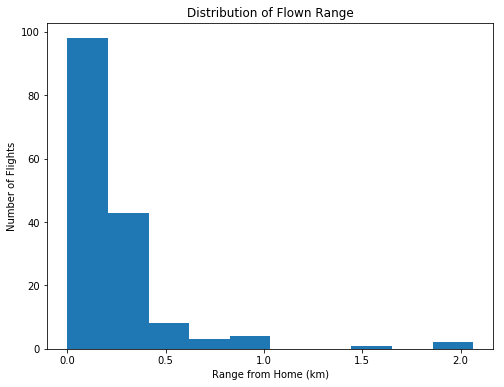

In [13]:
# Plot the distribution of range from start
# Requires data/ranges.npy from range.py
ranges = np.load('data/ranges.npy') / 1000
mean = np.mean(ranges)
median = np.median(ranges)
max_d = np.max(ranges)
min_d = np.min(ranges[np.nonzero(ranges)])
ranges = ranges[ranges < 3]

fig = plt.figure(figsize=(8, 6))
plt.hist(ranges)
plt.xlabel('Range from Home (km)')
plt.ylabel('Number of Flights')
plt.title("Distribution of Flown Range")

print('Mean range: %.1f km' % (mean))
print('Median range: %.1f km' % (median))
print('Max range: %.1f km' % (max_d))
print('Min range: %.1f km' % (min_d))
plt.savefig('outputs/ranges.png')

Mean distance: 3 km
Median distance: 3 km
Max distance: 19 km
Min distance: 0 km


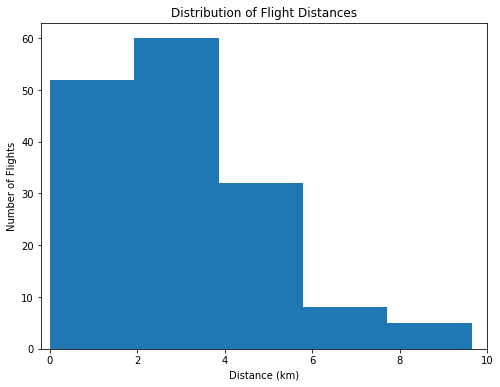

In [14]:
# Plot distance histogram
# distances.npy is generated by distance.py
distances = np.load('data/distances.npy') / 1000
fig = plt.figure(figsize=(8,6))
plt.hist(distances)
plt.xlabel('Distance (km)')
plt.xlim(-0.2, 10)
plt.ylabel('Number of Flights')
plt.title('Distribution of Flight Distances')
mean = np.mean(distances)
median = np.median(distances)
max_d = np.max(distances)
min_d = np.min(distances[np.nonzero(distances)])

print('Mean distance: %.0f km' % (mean))
print('Median distance: %.0f km' % (median))
print('Max distance: %.0f km' % (max_d))
print('Min distance: %.0f km' % (min_d))
plt.savefig('outputs/distances.png')

In [15]:
def check_overlap(rect1, rect2):
    '''Checks if the specified rectangles overlap'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))

    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    r2_min = np.amin(rect2, 0)
    r2_max = np.amax(rect2, 0)

    if r1_min[0] > r2_max[0] or r2_min[0] > r1_max[0]:
        return False
    if r1_min[1] > r2_max[1] or r2_min[1] > r2_max[1]:
        return False
    return True

def combine_area(rect1, rect2):
    ''' Combines the two rectangles to max extents'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))

    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    r2_min = np.amin(rect2, 0)
    r2_max = np.amax(rect2, 0)

    gb_min = np.amin([r1_min, r2_min], 0)
    gb_max = np.amax([r1_max, r2_max], 0)
    return np.array([gb_min,
                    [gb_min[0], gb_max[1]],
                    gb_max,
                    [gb_max[0], gb_min[1]]])

def reorder_extent(rect1):
    ''' Sorts extent corners into clockwise direction'''
    assert(isinstance(rect1, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    return np.array([r1_min,
                    [r1_min[0], r1_max[1]],
                    r1_max,
                    [r1_max[0], r1_min[1]]])

def distance_between_ll(rect1, rect2):
    '''Returns the minimum distance in meters between two nonoverlapping areas'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))
    assert(not check_overlap(rect1, rect2))
    r1 = utm.from_latlon(rect1[0, 0], rect1[0, 1])
    r2 = utm.from_latlon(rect2[0, 0], rect2[0, 1])
    if r1[2] != r2[2] or r1[3] != r2[3]:
        return 9e9
    r1 = np.array([utm.from_latlon(rect1[i, 0], rect1[i, 1])[0:2] for i in range(len(rect1))])
    r2 = np.array([utm.from_latlon(rect2[i, 0], rect2[i, 1])[0:2] for i in range(len(rect1))])
    return distance_between(r1, r2)

def distance_between(r1, r2):
    assert(isinstance(r1, np.ndarray))
    assert(isinstance(r2, np.ndarray))
    assert(r1.shape == (4, 2))
    assert(r2.shape == (4, 2))
    assert(np.issubdtype(r1.dtype, np.number))
    assert(np.issubdtype(r2.dtype, np.number))
    
    
    r1_min = np.amin(r1, axis=0)
    r1_max = np.amax(r1, axis=0)
    r2_min = np.amin(r2, axis=0)
    r2_max = np.amax(r2, axis=0)
    
    if (r2_min[0] > r1_min[0] and r2_min[0] < r1_max[0]) or (r2_max[0] > r1_min[0] and r2_max[0] < r1_max[0]):
        # check min vert
        return np.min([r2_min[0] - r1_max[0], r1_min[0] - r2_max[0]])
    elif (r2_min[1] > r1_min[1] and r2_min[1] < r1_max[1]) or (r2_max[1] > r1_min[1] and r2_max[1] < r1_max[1]):
        return np.min([r2_min[1] - r1_min[1], r1_min[1] - r2_max[1]])
    else:
        return np.min([np.linalg.norm(r1_min - r2_max), np.linalg.norm(r2_min - r1_max),
                      np.linalg.norm(np.array([r1_min[0], r1_max[1]]) - np.array([r2_max[0], r2_min[1]])),
                      np.linalg.norm(np.array([r2_min[0], r2_max[1]]) - np.array([r1_max[0], r1_min[1]]))])

In [48]:
# Plot flight areas
# flight_extents.npy is generated by plot_flight_extents.py
all_extents_orig = np.load('data/flight_extents.npy')
all_extents = np.array([reorder_extent(extent) for extent in all_extents_orig])
flight_area_extents = []
MIN_DIST_AREA = 500

while True:
    num_extents = len(all_extents)
    while len(all_extents) > 0:
        combined = False
        flight_area = all_extents[0]
        combined_areas = [0]
        for i in range(1, len(all_extents)):
            if check_overlap(flight_area, all_extents[i]):
                flight_area = combine_area(flight_area, all_extents[i])
                combined_areas.append(i)
                combined = True
            elif distance_between_ll(flight_area, all_extents[i]) < MIN_DIST_AREA:
                flight_area = combine_area(flight_area, all_extents[i])
                combined_areas.append(i)
                combined = True
        flight_area_extents.append(flight_area)
        all_extents = [all_extents[i] for i in range(len(all_extents)) if i not in combined_areas]
    if len(flight_area_extents) == num_extents:
        break
    else:
        all_extents = flight_area_extents
        flight_area_extents = []
flight_area_extents = sorted(flight_area_extents, key=lambda x: x[0][1])

flight_area_stats = [0] * len(flight_area_extents)
for flight in all_extents_orig:
    for i in range(len(flight_area_extents)):
        if check_overlap(flight, flight_area_extents[i]) == True:
            flight_area_stats[i] += 1
            break

flight_areas = [np.mean(flight_area_extent, axis=0) for flight_area_extent in flight_area_extents]

folium_map = folium.Map(width=1000,height=500, location=(np.amax(np.array(flight_areas), axis=0)+np.amin(np.array(flight_areas), axis=0)) / 2,
                        zoom_start=4.4,
                        tiles="openstreetmap")
locations=['Berkeley', 'Napa Valley', 'Riverside', 
           'Warren Canyon', 'La Jolla', 'Black Mountain', 
           'Valley of the Moon', 'Yuha Desert', 'Cayman Islands']


for i in range(len(flight_areas)):
    marker = folium.Marker(location=[flight_areas[i][0], flight_areas[i][1]], tooltip=locations[i] )
    marker.add_to(folium_map)
    extent = folium.Polygon(locations=flight_area_extents[i].tolist())
    extent.add_to(folium_map)
folium_map.save('outputs/extents.html')
folium_map

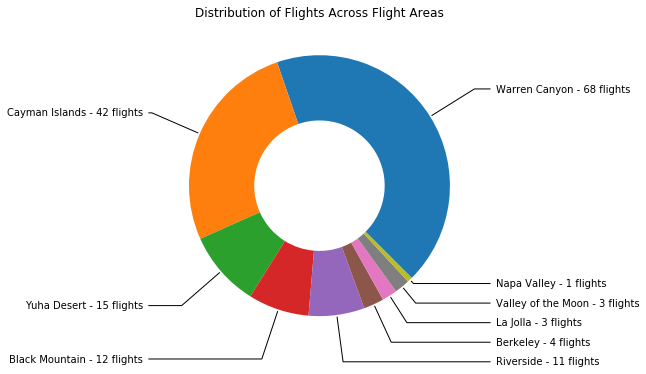

In [17]:
# Plots the distribution of flights across flight areas
# Please run the cell above first!

flight_area_stats, locations = zip(*sorted(zip(flight_area_stats, locations), key=lambda x: x[0], reverse=True))
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0]
fig, ax = plt.subplots(figsize=(10,6))
patches, texts = plt.pie(flight_area_stats, explode=explode, pctdistance=0.8, radius=1, startangle=-45, wedgeprops=dict(width=0.5))
patches, labels, dummy =  zip(*sorted(zip(patches, ['%s - %d flights' % 
    (locations[i], flight_area_stats[i]) for i in range(len(flight_area_stats))], flight_area_stats),
                                          key=lambda x: x[2],
                                          reverse=True))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=0.75)

kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
y_text = [0.7414959404949555,
         0.5580373055101346,
         -0.9191783365522787,
         -1.3284555246835867,
         -1.35,
         -1.2,
         -1.05,
         -0.9,
         -0.75]
for i, p in enumerate(patches):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), y_text[i]),
                horizontalalignment=horizontalalignment, **kw)
# plt.legend(patches, labels,bbox_to_anchor=(1, 1.))
plt.title('Distribution of Flights Across Flight Areas')
plt.savefig('outputs/areas.png')

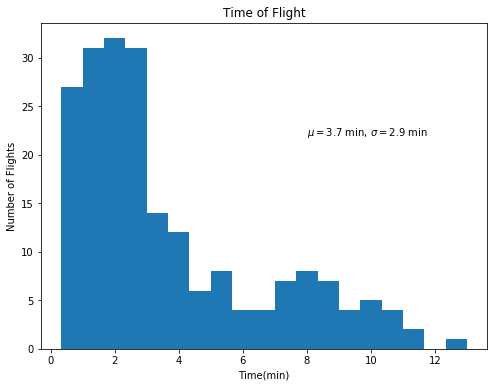

In [18]:
# Plot distribution of flight times
# dates.pkl comes from the data_analysis_kazim.py script
df = pd.read_pickle('data/dates.pkl')
df = df[['Flight Date','Flight Durations']]
df = df[~df['Flight Date'].isnull()]
df = df.groupby('Flight Date').agg(sum)
df['Flight Durations'] = df['Flight Durations'].apply(lambda x: sorted(x))
list_of_all_durations = []
for i in range(0,len(df['Flight Durations'])):
    old_list = df['Flight Durations'][i]
    new_list = [x/60 for x in old_list if x>20]
    list_of_all_durations.extend(new_list)
bins = np.linspace((min(list_of_all_durations)),(max(list_of_all_durations)),20) # fixed number of bins

fig = plt.figure(figsize=(8, 6))
# plt.xlim([min(list_of_all_durations), max(list_of_all_durations)])

plt.hist(list_of_all_durations, bins=bins)
# plt.grid(axis='y')
plt.title('Time of Flight')
plt.text(8, 22, r'$\mu = %.1f $ min, $\sigma = %.1f $ min' % (np.mean(list_of_all_durations), np.std(list_of_all_durations)))
plt.xlabel('Time(min)')
plt.ylabel('Number of Flights')
plt.savefig('outputs/flight_times.png')

Mean flights: 7.1


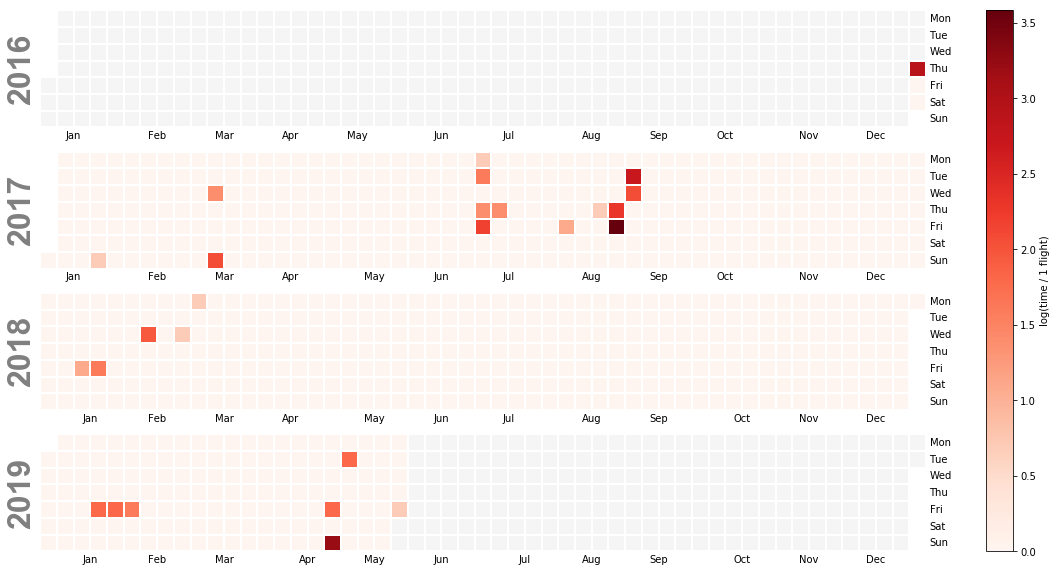

In [19]:
# Plots the calendar of flight operations
# dates.pkl comes from data_analysis_kazim.py script
df = pd.read_pickle('data/dates.pkl')
df = df[['Flight Date','Number of Flights','Flight Durations']]
#df = df[['Flight Date','Number of Flights']]
df = df[~df['Flight Date'].isnull()]
df = df.groupby(['Flight Date']).agg(sum) 
numFlights = []

# for i in range(0,len(df['Flight Durations'])):
for date in df.index:
    pass
#     old_list = 
#     new_list = 
    df.at[date, 'Flight Durations'] = [x for x in df.at[date, 'Flight Durations'] if x>20]
    numFlights.append(len(df.at[date, 'Flight Durations']))


df['Number of Flights'] = (numFlights)
df['Number of Flights'] = np.log(numFlights)
mean = np.mean(numFlights)
# df = df.reindex(df.index.repeat(df['Number of Flights']))
s = df['Number of Flights']
s.index = pd.to_datetime(s.index)
# # fig, ax = calmap.calendarplot(s)
# # plt.show()

fig,ax = calmap.calendarplot(s,fig_kws=dict(figsize=(17,8)), yearlabel_kws={'color':'grey'})

# fig.colorbar()
cbar = fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
cbar.set_label('log(time / 1 flight)')
plt.savefig('outputs/calendar.png')
print("Mean flights: %.1f" % (mean))

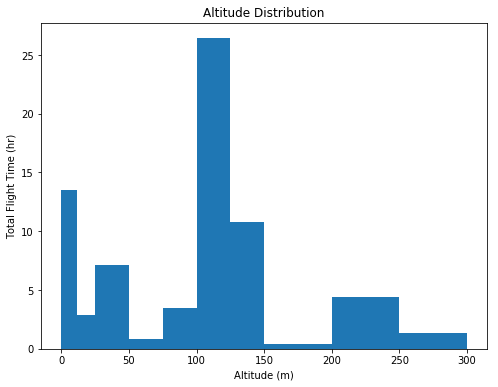

In [20]:
# Plotting the distribution of altitudes flown
# Relies on data/altitudes.pkl, which is generated by data_analysis_kazim.py
with open('data/altitudes.pkl', 'rb') as f:
    df_list = pickle.load(f)
# #df = df['Alt']
bins = [0,12,25,50,75,100,125,150,200,250,300]
widths = [bins[i+1] - bins[i] for i in range(len(bins) - 1)]
bin_vals = [0] * (len(bins) - 1)
for df in df_list:
    df['binned'] = pd.cut(df['Alt'], bins)
    s = df.groupby(pd.cut(df['Alt'], bins=bins)).size()
    df = pd.DataFrame({"Time Spent (s)": s.values},
                      index=s.index)
    for i in range(len(bin_vals)):
        bin_vals[i] += df.iloc[i, 0]
total = np.sum(bin_vals)
bin_vals = [bin_val / 3600 for bin_val in bin_vals]
fig = plt.figure(figsize=(8, 6))
plt.bar(bins[0:-1], bin_vals, width=widths, align='edge')
plt.xlabel('Altitude (m)')
plt.ylabel('Total Flight Time (hr)')
plt.title("Altitude Distribution")
plt.savefig('outputs/altitude.png')

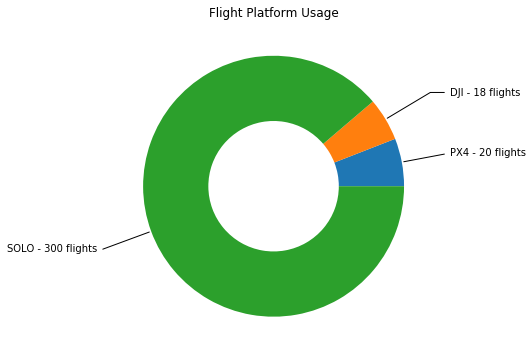

In [21]:
# Plot flight platform types
# Requires data/types.pkl generated from types.py
with open('data/types.pkl', 'rb') as f:
    retval = pickle.load(f)
acft_usage = {}
for log in retval:
    if log is None:
        continue
    if log[1] == 0:
        continue
    if log[0] in acft_usage:
        acft_usage[log[0]] += log[1]
    else:
        acft_usage[log[0]] = log[1]

fig, ax = plt.subplots(figsize=(8, 6))
patches, texts = plt.pie(acft_usage.values(), wedgeprops=dict(width=0.5))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=0.75)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(patches):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate("%s - %d flights" % (list(acft_usage.keys())[i], list(acft_usage.values())[i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.title('Flight Platform Usage')
plt.savefig('outputs/flight_platforms.png')

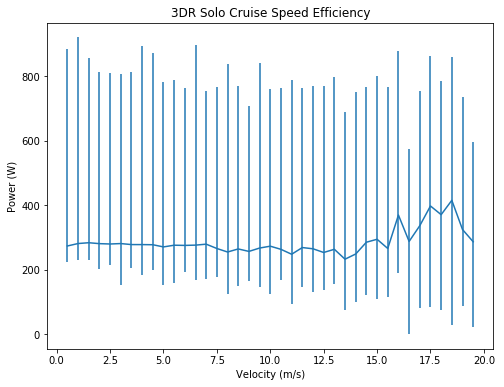

In [22]:
# Cruising Speed
# Requires data/solo_vel_cur.pkl from extract_current.py
acft_type = 'SOLO'

if acft_type == 'SOLO':
    with open('data/solo_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'DJI':
    with open('data/dji_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'PX4':
    with open('data/px4_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
fig = plt.figure(figsize=(8, 6))
datalist = []
for log in results:
    if log is None:
        continue
    datalist += list(log.values())
datalist = [data for data in datalist if data[1] > 50 and data[0] < 20]
data = np.array(datalist)

df = pd.DataFrame(data = data, columns=['velocity', 'power'])
df['v_q'] = pd.np.digitize(df.velocity, np.arange(0, int(np.ceil(df.velocity.max())), 0.5)) * 0.5
df1 = df.groupby('v_q').agg(["mean", np.min, np.max]).dropna()
df1['power']['mean'].to_numpy()
df1['power'][['amin','amax']].to_numpy()
list(df1.index)
plt.errorbar(list(df1.index), df1['power']['mean'].to_numpy(), yerr=df1['power'][['amin', 'amax']].to_numpy().transpose())
plt.ylabel('Power (W)')
plt.xlabel('Velocity (m/s)')
if acft_type == 'SOLO':
    plt.title('3DR Solo Cruise Speed Efficiency')
    plt.savefig('outputs/solo_cruise_speed.png')
elif acft_type == 'DJI':
    plt.title('DJI Phantom Cruise Speed Efficiency')
    plt.savefig('outputs/dji_cruise_speed.png')
elif acft_type == 'PX4':
    plt.title('PX4 Cruise Speed Efficiency')
    plt.savefig('outputs/px4_cruise_speed.png')


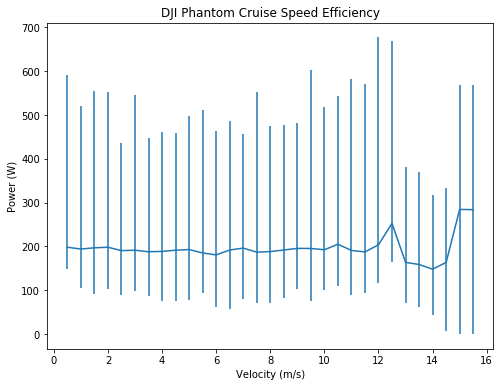

In [23]:
# Cruising Speed
# Requires data/dji_vel_cur.pkl from extract_current.py
acft_type = 'DJI'

if acft_type == 'SOLO':
    with open('data/solo_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'DJI':
    with open('data/dji_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'PX4':
    with open('data/px4_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
fig = plt.figure(figsize=(8, 6))
datalist = []
for log in results:
    if log is None:
        continue
    datalist += list(log.values())
datalist = [data for data in datalist if data[1] > 50 and data[0] < 20]
data = np.array(datalist)

df = pd.DataFrame(data = data, columns=['velocity', 'power'])
df['v_q'] = pd.np.digitize(df.velocity, np.arange(0, int(np.ceil(df.velocity.max())), 0.5)) * 0.5
df1 = df.groupby('v_q').agg(["mean", np.min, np.max]).dropna()
df1['power']['mean'].to_numpy()
df1['power'][['amin','amax']].to_numpy()
list(df1.index)
plt.errorbar(list(df1.index), df1['power']['mean'].to_numpy(), yerr=df1['power'][['amin', 'amax']].to_numpy().transpose())
plt.ylabel('Power (W)')
plt.xlabel('Velocity (m/s)')
if acft_type == 'SOLO':
    plt.title('3DR Solo Cruise Speed Efficiency')
    plt.savefig('outputs/solo_cruise_speed.png')
elif acft_type == 'DJI':
    plt.title('DJI Phantom Cruise Speed Efficiency')
    plt.savefig('outputs/dji_cruise_speed.png')
elif acft_type == 'PX4':
    plt.title('PX4 Cruise Speed Efficiency')
    plt.savefig('outputs/px4_cruise_speed.png')


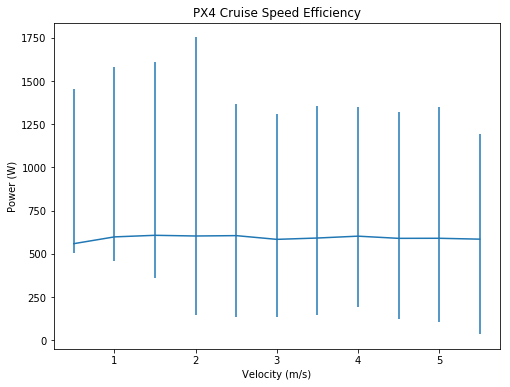

In [24]:
# Cruising Speed
# Requires data/px4_vel_cur.pkl from extract_current.py
acft_type = 'PX4'

if acft_type == 'SOLO':
    with open('data/solo_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'DJI':
    with open('data/dji_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
elif acft_type == 'PX4':
    with open('data/px4_vel_cur.pkl', 'rb') as f:
        results = pickle.load(f)
fig = plt.figure(figsize=(8, 6))
datalist = []
for log in results:
    if log is None:
        continue
    datalist += list(log.values())
datalist = [data for data in datalist if data[1] > 50 and data[0] < 20]
data = np.array(datalist)

df = pd.DataFrame(data = data, columns=['velocity', 'power'])
df['v_q'] = pd.np.digitize(df.velocity, np.arange(0, int(np.ceil(df.velocity.max())), 0.5)) * 0.5
df1 = df.groupby('v_q').agg(["mean", np.min, np.max]).dropna()
df1['power']['mean'].to_numpy()
df1['power'][['amin','amax']].to_numpy()
list(df1.index)
plt.errorbar(list(df1.index), df1['power']['mean'].to_numpy(), yerr=df1['power'][['amin', 'amax']].to_numpy().transpose())
plt.ylabel('Power (W)')
plt.xlabel('Velocity (m/s)')
if acft_type == 'SOLO':
    plt.title('3DR Solo Cruise Speed Efficiency')
    plt.savefig('outputs/solo_cruise_speed.png')
elif acft_type == 'DJI':
    plt.title('DJI Phantom Cruise Speed Efficiency')
    plt.savefig('outputs/dji_cruise_speed.png')
elif acft_type == 'PX4':
    plt.title('PX4 Cruise Speed Efficiency')
    plt.savefig('outputs/px4_cruise_speed.png')


In [25]:
# Plots the calendar of flight operations
# dates.pkl comes from data_analysis_kazim.py script
df = pd.read_pickle('data/dates.pkl')
df = df[['Flight Date','Flight Durations']]
df = df[~df['Flight Date'].isnull()]
df = df.groupby('Flight Date').agg(sum)
#df['Flight Durations'] = df['Flight Durations'].apply(lambda x: sorted(x))

for i in range(0,len(df['Flight Durations'])):
    old_list = df['Flight Durations'][i]
    new_list = [x / 60 for x in old_list if x>20]
    df['Flight Durations'][i] = new_list

flights = df['Flight Durations'].apply(pd.Series)
flights = flights.rename(columns = lambda x : 'Flight ' + str(x))

%opts Bars [tools=['hover'],color_index='Variable',width=900,height=400](alpha=0.5,color=hv.Palette('Category20'))
plot = flights.hvplot.bar(stacked=True,rot=45,legend=False).redim(value=hv.Dimension('value',label='Duration')).opts(ylabel='Duration (min)')


hvplot.save(plot, 'outputs/flight_breakdown.html')
hvplot.save(plot, 'outputs/flight_breakdown.png')
plot

:Bars   [Flight Date,Variable]   (value)